# This is the first step in the pipeline
### Spots are detected in this notebook. The input file is expected to be in the zarr format 

In [58]:
import pandas as pd
import time
import os
import sys
import zarr
import napari 
import dask.array as da 

pythonPackagePath = os.path.abspath('../src/')
sys.path.append(pythonPackagePath)
from parallel import Detector
from gaussian_visualization import visualize_3D_gaussians

### Do not change the code in cell below 

In [59]:
# This assumes that your notebook is inside 'Jupyter Notebooks', which is at the same level as 'test_data'
# base_dir = os.path.join(os.path.dirname(os.path.abspath("__file__")), '..', 'movie_data')
base_dir = os.path.join(os.path.dirname(os.path.abspath("__file__")), '..', 'test_movie_1')

zarr_directory = 'zarr_file/all_channels_data'
zarr_full_path = os.path.join(base_dir, zarr_directory)

save_directory = 'datasets'
save_directory_full = os.path.join(base_dir, save_directory)

## Follow the Instructions below to run through the notebook properly 

The purpose of this notebook is to perform spot detection on your full movie. The movie is expected to be a 3 channel movie which is saved as a zarr object. If your movie is not a zarr object you can convert it to a zarr object by running and following the steps provided to you under Final/Data Preparation/full_movie_to_zarr.ipynb

**For Initialising the Detector Object** 

1. Detector object is the main object for which you will setup the parameters to work in this notebook. 
2. **zarr_obj**: is the object which efficiently stores the movie 
3. **save_directory**: is fixed and does not need to be changed. However, for reference the files from this notebook will be outputted and saved in Final/movie_data/datasets directory 
4. **spot_intensity**: This is the minimum intensity which a spot will have in your movie. Anything below this can be called noise/background. You can determine the spot_intensity using fiji or napari to determine minimum bright spots which are of interest. If you set a spot_intensity too high very few spots will be detected, however, if you set a intensity too low a lot of spots including a lot of noise will be detected. 
5. **dist_between_spots**: this distance divided by 2 is the minimum distance that should exist between spots in pixels. For example if you set this to 10 then all spots within 5 pixels of the center of your spot will be dropped(to understand which spot is dropped you can refer to the source code in the Final/src/gaussian_fitting.py file)
6. **sigma_estimations**: This is the spread/radius of your spots from the center. It is entered in pixels and follows the order [z,y,x]. If you expect your spot to have a radius of 4 in z and 2 in x and y then you should enter [4,2,2]. To determine the spread/radius of your spot you can visualise in fiji and look at the metadata to understand the pixel radius. 
7. **n_jobs**: Detector class allows for parallel processing and the number of cores you want to use can be determined here. You can set it to -1 and it will use all_cores - 1 for processing. It is important to allow for parallel processing else for larger movies it will take a lot of time. 
8. **channel_to_detect**: The number of channel to detect. Convention is 1 for channel 1, 2 for channel 2 and 3 for channel 3. The detector object can only detect one channel at a time. 

**For running processing on frames** (run_parallel_frame_processing)

1. **max_frames**: the maximum frames to process. This can be useful when you just want to test your parameters selected for the Detector object like spot_intensity, dist_between_spots and sigma_estimates. 
2. **all_frames**: If all frames is set to True then all frames are processed and the **max_frames** parameter is ignored. It is recommended to initially decide all the parameters on a subset of frames and then move onto this step as it may take a lot of time for larger movies. 


**Note**

-> Cores to be utilized can be increased as available. Keep in mind that limitation can be posed by the RAM of your machine. As more cores are utilized more RAM is needed. 

-> Detection can be only performed on 1 channel at a time


## Set all parameters in the below cell 

In [92]:
#refer to the above cell for explanation of each parameter 
spot_intensity = 180
dist_between_spots = 10
sigma_estimations = [4,2,2]
quality_threshold_mu = 1
quality_threshold_sigma = 2.5
n_jobs = -1
channel_to_detect = 3 
max_frames = 2 
all_frames = False

In [93]:
#Import the zarr file by adding file path in read mode
z2 = zarr.open(zarr_full_path, mode='r')

In [94]:
z2.info

Type,zarr.core.Array
Data type,uint16
Shape,"(130, 3, 75, 150, 275)"
Chunk shape,"(1, 1, 75, 150, 275)"
Order,C
Read-only,True
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,2413125000 (2.2G)
No. bytes stored,656696875 (626.3M)
Storage ratio,3.7


In [95]:
frames = z2.shape[0]
print(f'the number of frames are {frames}')

the number of frames are 130


## In the below cell Detector object is initilized to perform detection. More details on the Detector object can be attained by the following line of code: 
**copy and paste in a new cell**

?Detector

In [96]:
detector = Detector(zarr_obj = z2, 
                    save_directory = save_directory_full, 
                    spot_intensity = spot_intensity, 
                    dist_between_spots = dist_between_spots, 
                    sigma_estimations = sigma_estimations, n_jobs = n_jobs, channel_to_detect = channel_to_detect)

In [97]:
#the following function returns the dataframe and also saves it to the provided path in pkl format
#set all_frames = True, to process all the time frames 
#max_frames is useful when you just want to perform detection on a subset of frames. 
#Note: when all_frames= True then max_frames is ignored 
df = detector.run_parallel_frame_processing(max_frames = max_frames, all_frames = all_frames)

Processing frames: 100%|██████████| 2/2 [00:03<00:00,  1.66s/it]

the number of times the gaussian fitting worked was 244 and the number of times the gaussian did not fit was 67
the number of times the gaussian fitting worked was 261 and the number of times the gaussian did not fit was 67


In [98]:

test = detector.run_parallel_frame_processing(max_frames = max_frames, all_frames = all_frames)
# print('testing now')


Processing frames: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]

the number of times the gaussian fitting worked was 244 and the number of times the gaussian did not fit was 67
the number of times the gaussian fitting worked was 261 and the number of times the gaussian did not fit was 67


In [99]:
# for each line in test, calculate the mean of errors[1] and errors[2]
# if the mean of errors[1] is greater than mu_threshold or mean of errors[2] is greater than sigma_threshold, then keep it in the dataframe test_2

# mu_threshold = 0.5
# sigma_threshold = 0.5
# counter_not_fit = 0
# index_of_maximas = []

test['mean_errors_mu'] = test['errors'].apply(lambda x: pd.Series(x[1]).mean())
test['mean_errors_sigma'] = test['errors'].apply(lambda x: pd.Series(x[2]).mean())


# if np.mean(mean_absolute_error_mean) > mu_threshold or np.mean(mean_absolute_error_sigmas) > sigma_threshold:
#                 #print('the gaussian did not fit')
#                 counter_not_fit += 1
#                 index_of_maximas.append(i)
test2 = test[(test['mean_errors_mu'] <= 1) & (test['mean_errors_sigma'] < 2.5)]
test3 = test[(test['mean_errors_mu'] > 1) & (test['mean_errors_sigma'] >= 2.5)]

test2

,amplitude,mu_x,mu_y,mu_z,sigma_x,sigma_y,sigma_z,cov_x,cov_y,cov_z,errors,frame,mean_errors_mu,mean_errors_sigma
1,191.000000,36.0,43.0,1.0,2.0,1.0,2.0,0.015020,0.045914,2367.853395,"[4.999999999999517, [0.802072230448214, 0.2164...",0,0.458639,0.800102
2,231.007679,40.0,96.0,1.0,2.0,2.0,2.0,0.015020,0.045914,2367.853395,"[3.9923205358078633, [0.946468875975939, 0.164...",0,0.611968,0.619822
3,185.152538,40.0,13.0,1.0,2.0,1.0,3.0,0.015020,0.045914,2367.853395,"[3.847461623190185, [0.5256193547833399, 0.389...",0,0.358392,0.536925
4,202.000000,46.0,28.0,1.0,2.0,2.0,3.0,0.015020,0.045914,2367.853395,"[4.999999999999972, [0.7257017362142371, 0.132...",0,0.338810,0.502196
5,199.000000,65.0,90.0,1.0,2.0,1.0,2.0,0.015020,0.045914,2367.853395,"[4.999999999999972, [0.8930416004280686, 0.024...",0,0.314858,0.614664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,354.333333,232.0,98.0,72.0,2.0,2.0,4.0,0.025821,2.079709,684.234816,"[1.6666666666666856, [0.1644772491307691, 0.02...",1,0.094144,0.339484
624,181.000000,238.0,65.0,71.0,2.0,1.0,2.0,0.025821,2.079709,684.234816,"[4.999999999999972, [1.2225698305084904, 0.199...",1,0.623773,0.482415
626,326.981614,138.0,55.0,75.0,2.0,2.0,5.0,0.025821,2.079709,684.234816,"[0.9816144068473136, [1.9585048014973552, 0.07...",1,0.818423,0.673568
628,219.331626,164.0,97.0,75.0,2.0,3.0,6.0,0.025821,2.079709,684.234816,"[0.6683738239880483, [1.3136994252425467, 0.28...",1,0.579871,1.555417


# Visualising the Output
## Labels are only for time frame 0, for all z slices 

In [105]:
import numpy as np
import zarr
import matplotlib.pyplot as plt



def create_cylindrical_mask_fast(shape, centers, radius_xy, radius_z):
    z_dim, y_dim, x_dim = shape
    mask = np.zeros((1,z_dim, y_dim, x_dim))
    
    one_frame_df = spots_df[spots_df['frame'] == 0].copy(deep = True)
    centers = one_frame_df[['mu_z', 'mu_y', 'mu_x']].values
    radius_xy = 2
    radius_z = 4
    Z, Y, X = np.ogrid[:z_dim, :y_dim, :x_dim]
    
    for center in centers:
        z_center, y_center, x_center = center
        
        distance_xy = np.sqrt((X - x_center) ** 2 + (Y - y_center) ** 2)
        mask_region = (distance_xy <= radius_xy) & (abs(Z - z_center) <= radius_z)
        mask[0][mask_region] = 255
    
    return mask


spots_df = df

one_frame_df = spots_df[spots_df['frame'] == 0].copy(deep = True)
centers = one_frame_df[['mu_z', 'mu_y', 'mu_x']].values
radius_xy = 2
radius_z = 4

masks4 = create_cylindrical_mask_fast([z2.shape[2], z2.shape[3], z2.shape[4]], centers, radius_xy, radius_z)
masks4






array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

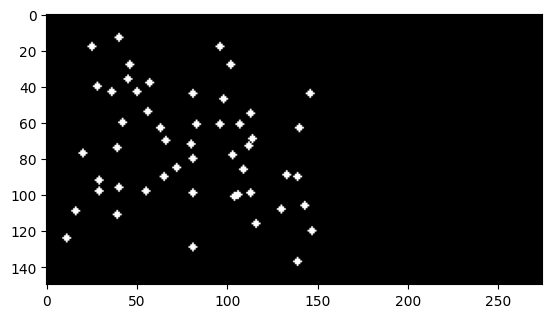

In [109]:
plt.imshow(masks4[0][0], cmap = 'gray')

In [ ]:
mask_shape = [z2.shape[2], z2.shape[3], z2.shape[4]]
radius_xy = 2
radius_z = 4
df_to_use = cleaned_df[cleaned_df[‘frame’] == 0].copy(deep = True)
centers = df_to_use[[‘mu_z’, ‘mu_y’, ‘mu_x’]].values
mask_all_cleaned = create_cylindrical_mask_fast(mask_shape, centers, radius_xy, radius_z)
# Initialize the array to store masks for all frames
frames = 100  # Assuming you want to create a mask for each frame in the time dimension
mask_all_frames = np.zeros((frames, z2.shape[2], z2.shape[3],z2.shape[4]))
for frame in range(frames):
    df_to_use = cleaned_df[cleaned_df[‘frame’] == frame].copy(deep = True)
   centers = df_to_use[[‘mu_z’, ‘mu_y’, ‘mu_x’]].values
    mask_all_cleaned = create_cylindrical_mask_fast(mask_shape, centers, radius_xy, radius_z)
    mask_all_frames[frame] = mask_all_cleaned

In [100]:
masks2 = visualize_3D_gaussians(zarr_obj = z2, gaussians_df = test2)
masks3 = visualize_3D_gaussians(zarr_obj = z2, gaussians_df = test3)

/Users/makamats/Repos/Image-Analysis-Tracking/Final/src/gaussian_visualization.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaussians_df['sigma_x'] = gaussians_df['sigma_x'].replace(0, 1)
/Users/makamats/Repos/Image-Analysis-Tracking/Final/src/gaussian_visualization.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaussians_df['sigma_y'] = gaussians_df['sigma_y'].replace(0, 1)
/Users/makamats/Repos/Image-Analysis-Tracking/Final/src/gaussian_visualization.py:27: SettingWithCopyWarning: 
A value i

In [110]:
# Create a napari viewer
viewer = napari.Viewer()

#access channel 3 only from zarr array 
dask_array = da.from_zarr(z2)

#the axis arrangement is (t,c,z,y,x)
#for the sake of improved performance only 1 channel could be imported here (if images get super large and performance issues occur)
all_channels = dask_array[:,:,:,:,:]

# Add the 4D stack to the viewer
# Can change the names of the channels as needed
layer_raw = viewer.add_image(all_channels, channel_axis = 1, name = ['actin', 'dynamin', 'clathrin'])
# layer_mask = viewer.add_image(masks, name = 'detections mask')
layer_mask_accepted = viewer.add_image(masks2, name = 'accepted detections mask', interpolation3d = 'nearest', blending = 'additive')
layer_mask_rejected = viewer.add_image(masks3, name = 'rejected detections mask', interpolation3d = 'nearest', blending = 'additive')
layer_mask_alt = viewer.add_image(masks4, name = 'alt detections mask', interpolation3d = 'nearest', blending = 'additive')

#other useful parameters 
#color_map = list
#contrast_limits = list of list 

# Add Bounding Box
layer_raw[0].bounding_box.visible = True
layer_raw[1].bounding_box.visible = True
layer_raw[2].bounding_box.visible = True

In [90]:
masks = visualize_3D_gaussians(zarr_obj = z2, gaussians_df = df)

KeyError: 'sigma_x'

### Below you can see detected spots as masks on the original image and can adjust detection parameters if needed 

In [10]:
# Create a napari viewer
viewer = napari.Viewer()

#access channel 3 only from zarr array 
dask_array = da.from_zarr(z2)

#the axis arrangement is (t,c,z,y,x)
#for the sake of improved performance only 1 channel could be imported here (if images get super large and performance issues occur)
all_channels = dask_array[:,:,:,:,:]

# Add the 4D stack to the viewer
# Can change the names of the channels as needed
layer_raw = viewer.add_image(all_channels, channel_axis = 1, name = ['actin', 'dynamin', 'clathrin'])
layer_mask = viewer.add_image(masks, name = 'detections mask')

#other useful parameters 
#color_map = list
#contrast_limits = list of list 

# Add Bounding Box
layer_raw[0].bounding_box.visible = True
layer_raw[1].bounding_box.visible = True
layer_raw[2].bounding_box.visible = True

/Users/makamats/opt/anaconda3/envs/cme_pipeline/lib/python3.10/site-packages/napari/_vispy/layers/image.py:251: UserWarning: data shape (112, 2052, 340) exceeds GL_MAX_TEXTURE_SIZE 2048 in at least one axis and will be downsampled. Rendering is currently in 3D mode.
  warnings.warn(
/Users/makamats/opt/anaconda3/envs/cme_pipeline/lib/python3.10/site-packages/napari/_vispy/layers/image.py:251: UserWarning: data shape (112, 2052, 340) exceeds GL_MAX_TEXTURE_SIZE 2048 in at least one axis and will be downsampled. Rendering is currently in 3D mode.
  warnings.warn(
/Users/makamats/opt/anaconda3/envs/cme_pipeline/lib/python3.10/site-packages/napari/_vispy/layers/image.py:251: UserWarning: data shape (112, 2052, 340) exceeds GL_MAX_TEXTURE_SIZE 2048 in at least one axis and will be downsampled. Rendering is currently in 3D mode.
  warnings.warn(


# move to 02.filtering_spots for next steps 